#### Programa de Formación en ML & DS
## Introducción al Aprendizaje Automático
# Sesión 8: Taller de Clasificación usando Imágenes 

In [0]:
!pip install tabulate

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import pylab as pl
from sklearn.datasets import make_circles
from matplotlib.colors import Normalize
import os


# Función para visualizar un conjunto de datos en 2D
def plot_data(X, y):
    y_unique = np.unique(y)
    colors = pl.cm.rainbow(np.linspace(0.0, 1.0, y_unique.size))
    for this_y, color in zip(y_unique, colors):
        this_X = X[y == this_y]
        pl.scatter(this_X[:, 0], this_X[:, 1],  c=color,
                    alpha=0.5, edgecolor='k',
                    label="Class %s" % this_y)
    pl.legend(loc="best")
    pl.title("Data")
    
# Función para visualizar de la superficie de decisión de un clasificador
def plot_decision_region(X, pred_fun):
    min_x = np.min(X[:, 0])
    max_x = np.max(X[:, 0])
    min_y = np.min(X[:, 1])
    max_y = np.max(X[:, 1])
    min_x = min_x - (max_x - min_x) * 0.05
    max_x = max_x + (max_x - min_x) * 0.05
    min_y = min_y - (max_y - min_y) * 0.05
    max_y = max_y + (max_y - min_y) * 0.05
    x_vals = np.linspace(min_x, max_x, 100)
    y_vals = np.linspace(min_y, max_y, 100)
    XX, YY = np.meshgrid(x_vals, y_vals)
    grid_r, grid_c = XX.shape
    ZZ = np.zeros((grid_r, grid_c))
    for i in range(grid_r):
        for j in range(grid_c):
            ZZ[i, j] = pred_fun(XX[i, j], YY[i, j])
    pl.contourf(XX, YY, ZZ, 100, cmap = pl.cm.coolwarm, vmin= -1, vmax=2)
    pl.colorbar()
    pl.xlabel("x")
    pl.ylabel("y")
    
class MidpointNormalize(Normalize):

    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))
    
def gen_pred_fun(clf):
    def pred_fun(x1, x2):
        x = np.array([[x1, x2]])
        return clf.predict(x)[0]
    return pred_fun

def list_cm(cm,classes):     #función para generar de una forma más visual la matriz de confusión
    if len(cm)==2:
      cm.astype(int)
      row_0 =['','Valor','Verdadero']
      row_1 =['-',classes[0],classes[1]]
      row_2 =[classes[0],cm[0,0],cm[1,0]]
      row_3 =[classes[1],cm[0,1],cm[1,1]]
      table = zip(row_0,row_1, row_2, row_3)
      headers = ['', '', 'Valor', 'Predicho']  
      return print(tabulate(table, headers=headers, floatfmt=".0f"))
    else:
      cm.astype(int)
      row_0 =['','Valor','Verdadero','']
      row_1 =['-',np.int(classes[0]),classes[1],classes[2]]
      row_2 =[classes[0],cm[0,0],cm[1,0],cm[2,0]]
      row_3 =[classes[1],cm[0,1],cm[1,1],cm[2,1]]
      row_4 =[classes[2],cm[0,2],cm[1,2],cm[2,2]]
      table = zip(row_0,row_1, row_2, row_3, row_4)
      headers = ['', '', 'Valor', 'Predicho', '']  
      return print(tabulate(table, headers=headers, floatfmt=".0f")) 

In [0]:
from skimage.feature import hog
from skimage import data, color, exposure
from PIL import ImageOps, Image
from sklearn.ensemble import RandomForestClassifier

def extract_histo(img):
    values_r, _ = np.histogram(img[:,:,0].ravel(), bins=256, range=(0.0, 256))
    values_g, _ = np.histogram(img[:,:,1].ravel(), bins=256, range=(0.0, 256))
    values_b, _ = np.histogram(img[:,:,2].ravel(), bins=256, range=(0.0, 256))
    return np.concatenate((values_r, values_g, values_b))

def extract_pixels(img, flatten=True):
    t_img = Image.fromarray(img)

    new_width  = 224
    new_height = 224
    test_img = ImageOps.fit(t_img, (new_width, new_height), Image.ANTIALIAS)
    test_img = test_img.convert('L')
    if flatten:
        return np.array(test_img).flatten()
    return np.array(test_img)

def extract_hog(img):
    t_img = Image.fromarray(img)

    new_width  = 224
    new_height = 224
    test_img = ImageOps.fit(t_img, (new_width, new_height), Image.ANTIALIAS) #
    image = color.rgb2gray(np.array(test_img))

    fd = hog(image, orientations=8, pixels_per_cell=(28, 28),
                    cells_per_block=(1, 1), visualise=False)
    return fd

In [0]:
!pip install pydrive

     |████████████████████████████████| 993kB 3.5MB/s 
  Stored in directory: /root/.cache/pip/wheels/fa/d2/9a/d3b6b506c2da98289e5d417215ce34b696db856643bad779f4
Successfully built pydrive


In [0]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
 
# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



In [0]:
file_list = drive.ListFile({'q': "'1xnD90n2DNZDeCldJj6q_hqLow43TbTKB' in parents and trashed=false"}).GetList()
for file1 in file_list:
  print('title: %s, id: %s' % (file1['title'], file1['id']))

title: mnist-original.mat, id: 1bj4r9e5dln5hquo2v0EJWNcJac_jtcbd
title: birds_f_numbers.txt, id: 1ZoRzgHiKEHHY2LgqGiD9Zs-34ZwB02Kr
title: birds, id: 1X8Uxqz-rvN33FHCTxUD-xUsCm4ANO18o
title: scene_categories, id: 1BPOxgRvgFLpSJ4SR7bhGmX_RYL4XegEw


In [0]:
file_list = drive.ListFile({'q': "'1X8Uxqz-rvN33FHCTxUD-xUsCm4ANO18o' in parents and trashed=false"}).GetList()
for file1 in file_list:
  print('title: %s, id: %s' % (file1['title'], file1['id']))

title: mandarin, id: 1qG0VFPz58FYZi_V4rFtBNekIP4f3Glvn
title: owl, id: 169MXYlQfF2MBQ703pJVbqTmc0TwEzZHY
title: egret, id: 1xfSh0zZHK6YfmMrFrYbXcOjW-NQquV2E
title: wood_duck, id: 18XsEoplXnvcJ4hIP26evBFJBAKQuQL5Q
title: toucan, id: 1KQXX7F7kBNLV8hn-elZsYP11J4FAT2SI
title: puffin, id: 12tsdXppoirVYvgopvyG-wGqbRX4rooMP


In [0]:
file_list = drive.ListFile({'q': "'1X8Uxqz-rvN33FHCTxUD-xUsCm4ANO18o' in parents and trashed=false"}).GetList()
list_dir_birds = []
for file1 in file_list:
  list_dir_birds.append(file1['id'])
for iBird in list_dir_birds:
  file_list = drive.ListFile({'q': "'" + iBird + "' in parents and trashed=false"}).GetList()
  for file1 in file_list:
    birds_file = drive.CreateFile({'id': file1['id']})
    birds_file.GetContentFile(file1['title'])

In [0]:
file_list = drive.ListFile({'q': "'169MXYlQfF2MBQ703pJVbqTmc0TwEzZHY' in parents and trashed=false"}).GetList()
for file1 in file_list:
  print('title: %s, id: %s' % (file1['title'], file1['id']))

title: owl100.jpg, id: 1-TEPLX33Cpo-Bs4YRo7Diy61Vlmv2O7n
title: owl099.jpg, id: 1KJOsfjvIyjV65jT_vceFeKK1Svn66Bip
title: owl098.jpg, id: 1OjtEHJdrDgKAWkAtny47UxMVjN7YYU2b
title: owl097.jpg, id: 1hag9Sh0BbwKO1XQv3M8X0TBBrKH7Ufkm
title: owl096.jpg, id: 1c6D-5riCaTbzeWRn1NSpuVIvuHwa24_y
title: owl084.jpg, id: 1qzIJ0KBvnGAx0fVQd1eXh4l4LwW1xYAL
title: owl095.jpg, id: 17xn7P7WEF77RGaCPI0FufjB3lonJHd5B
title: owl094.jpg, id: 165fhaG60gN7Wnpq8z7vC01UJbXhpm3f-
title: owl093.jpg, id: 1i6CfE_ZZsmJD359kJsy9HtXeicyT1DIH
title: owl083.jpg, id: 1rXb5019rjsQ2WlHJAJCxEg2jllvgQanh
title: owl089.jpg, id: 1YePfboWwGiHPH6kqPQSAoBjyjJ4_36Yr
title: owl088.jpg, id: 1fwA6jfUxVoZK6vnsnsKm7hppuTYExKR-
title: owl082.jpg, id: 1wAEAYK8Dgoq975Nu_Mw4OoZPg24KlaPt
title: owl086.jpg, id: 1zVae5vzjNjKlRqvzgeQAPHIpWIwv7r2W
title: owl092.jpg, id: 1QXFJVgxg-jaaPDDdNFsn75lMD8CwVoTs
title: owl087.jpg, id: 1iirrPm8CBviAzKRgk1bOYqfXGgSVVZPd
title: owl091.jpg, id: 1fVcH6FwVZvHEO4D2FNeUY_21FZa6m4Hs
title: owl090.jpg, id: 186zGAQs

In [0]:
image_owl = drive.CreateFile({'id': '1jzqVLaI7LSk554AIfk2EkrcNusMpizkV'})
image_owl.GetContentFile('owl003.jpg')
img=mpimg.imread('owl003.jpg')

En esta segunda parte vamos a trabajar usando un par de conjuntos de clasificación un poco más complicados. A continuación trabajaremos con el conjunto de datos `birds`. `Birds` contiene las imágenes de 600 aves que pertenecen a 6 especies. Cada una con 100 imágenes.

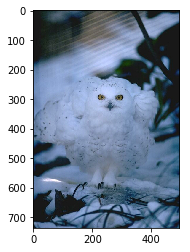

In [0]:
imgplot = plt.imshow(img)

Armamos el conjunto de datos:

In [0]:
birds_file = drive.CreateFile({'id': '1ZoRzgHiKEHHY2LgqGiD9Zs-34ZwB02Kr'})
birds_file.GetContentFile('birds_f_numbers.txt')

with open('birds_f_numbers.txt', 'r') as f:
    f = f.readlines()

In [0]:
bird_classes = ['egr', 'man', 'owl', 'puf', 'tou', 'wod']

In [0]:
train_test_indices = [x.strip() for x in f[7:]]
train_test_indices = [x for x in train_test_indices if len(x)>0]

Clases

In [0]:
https://drive.google.com/drive/folders/1FB06DTgTcQWxO2tLvOLoQPZ0LJXuUmF0?usp=sharing

In [0]:
file_list = drive.ListFile({'q': "'1FB06DTgTcQWxO2tLvOLoQPZ0LJXuUmF0' in parents and trashed=false"}).GetList()
for file1 in file_list:
  print('title: %s, id: %s' % (file1['title'], file1['id']))

title: egr097.jpg, id: 1o3PNN3acHMwSlt3lA7tPDvxSgkUXhu9K
title: egr096.jpg, id: 1GN7nHCnRJxGJR3PN2rKYUbHGJfLoAzB6
title: egr100.jpg, id: 1gUSKej8Pah04paSmAfteqICdVxU5JSdj
title: egr095.jpg, id: 1jf2nkE-UfwRfQWUX7Pd9TcnzwhhCt13z
title: egr092.jpg, id: 1ctIf5AhH2Mc0Jq7zU1ywsfhd66xZk0Zn
title: egr091.jpg, id: 1OKyiv8NPu1EHXl53NcbQG2tFFctr6AuH
title: egr093.jpg, id: 1BBDF9AlxKrR1s0Udwwpja5Pib6w-Fk30
title: egr099.jpg, id: 16mlOq03OWcVvn2g1QkGbgWLGE-cne6Xn
title: egr098.jpg, id: 1d9lu7jC0TJgDGEozYUITR8XOhoJ1jdib
title: egr094.jpg, id: 17jTazEvmiJQrx3cW83AdoxG8kmX1cfPA
title: egr090.jpg, id: 1pXbhWz6C5QcTz-U76d9fnuiKB7GzwaAq
title: egr089.jpg, id: 12zMstkrITk7jwuOufbjm69OP7MxpLXra
title: egr084.jpg, id: 1LKBJN8wK8Y7dMao4vdzkZJ8m8TQz1ljW
title: egr083.jpg, id: 1EgD404bo-8BE6aODKcPCkxvWpqAuXANx
title: egr082.jpg, id: 1oJP3MU4fDvnYL9fGLpDQ0EcCcZ7eIiA2
title: egr088.jpg, id: 1OEQ6KzgFKrh6zUrUessBG7TTMAVOiB7p
title: egr081.jpg, id: 1M0kZ7SuGmzDCPR4oxZ_jiiV5Jhh9qdFA
title: egr086.jpg, id: 1jd5pFRu

In [0]:
class_to_ix = {cls:i for i, cls in enumerate(bird_classes)}

print(class_to_ix)

{'egr': 0, 'man': 1, 'owl': 2, 'puf': 3, 'tou': 4, 'wod': 5}


In [0]:
from google.colab import drive

In [0]:
drive.mount("/content/drive", force_remount=False)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
session_path = "content/drive/My Drive/Programa_formación_mlds_2019/Nivel básico/2019-1B/MLDS-2/Recursos y talleres /M2 - S8_ Clasificación de imágenes"

In [0]:
train_files = []
val_files = []
test_files = []
y_train = []
y_val = []
y_test = []


for i, idx_class in zip(range(0, 606, 101), bird_classes):
  bird_class = train_test_indices[i]
  train_files.extend([idx_class + train_test_indices[x].zfill(3) + '.jpg' for x in range(i+1, i+21, 1)])
  y_train.extend([class_to_ix[idx_class]]*20)
  val_files.extend([idx_class + train_test_indices[x].zfill(3) + '.jpg' for x in range(21+i, i+51, 1)])
  y_val.extend([class_to_ix[idx_class]]*30)
  test_files.extend([idx_class + train_test_indices[x].zfill(3) + '.jpg' for x in range(51+i, i+101, 1)])
  y_test.extend([class_to_ix[idx_class]]*50)

In [0]:
train = [mpimg.imread(filename) for filename in train_files]
val = [mpimg.imread(filename) for filename in val_files]
test = [mpimg.imread(filename) for filename in test_files]

/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 80000 bytes but only got 0. Skipping tag 64640
  " Skipping tag %s" % (size, len(data), tag))
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 2652897280 bytes but only got 0. Skipping tag 2
  " Skipping tag %s" % (size, len(data), tag))
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 2656043008 bytes but only got 0. Skipping tag 2
  " Skipping tag %s" % (size, len(data), tag))
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 65536 bytes but only got 0. Skipping tag 3
  " Skipping tag %s" % (size, len(data), tag))
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting

Definimos una función para transformar cualquier imagen a escala de grises

In [0]:
import cv2
def to_gray(color_img):
    gray = cv2.cvtColor(color_img, cv2.COLOR_BGR2GRAY)
    return gray

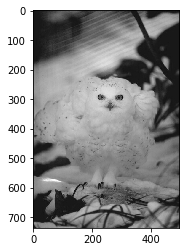

In [0]:
imgplot = plt.imshow(to_gray(img), cmap='gray')

También será útil una función que permita escalar las imágenes

Cambie `fun` por la función de extracción de características deseada

# Extracción de características

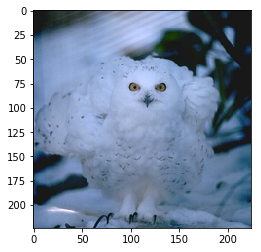

In [0]:
from PIL import Image 
t_img = Image.fromarray(img)

new_width  = 224
new_height = 224
test_img = ImageOps.fit(t_img, (new_width, new_height), Image.ANTIALIAS)

plt.imshow(test_img)

In [0]:
from skimage.feature import hog
from skimage import data, color, exposure
from PIL import ImageOps, Image
from sklearn.ensemble import RandomForestClassifier

def extract_histo(img):
    values_r, _ = np.histogram(img[:,:,0].ravel(), bins=256, range=(0.0, 256))
    values_g, _ = np.histogram(img[:,:,1].ravel(), bins=256, range=(0.0, 256))
    values_b, _ = np.histogram(img[:,:,2].ravel(), bins=256, range=(0.0, 256))
    return np.concatenate((values_r, values_g, values_b))

def extract_pixels(img, flatten=True):
    t_img = Image.fromarray(img)

    new_width  = 224
    new_height = 224
    test_img = ImageOps.fit(t_img, (new_width, new_height), Image.ANTIALIAS)
    test_img = test_img.convert('L')
    if flatten:
        return np.array(test_img).flatten()
    return np.array(test_img)

def extract_hog(img):
    t_img = Image.fromarray(img)

    new_width  = 224
    new_height = 224
    test_img = ImageOps.fit(t_img, (new_width, new_height), Image.ANTIALIAS) #
    image = color.rgb2gray(np.array(test_img))

    fd = hog(image, orientations=8, pixels_per_cell=(28, 28),
                    cells_per_block=(1, 1), visualise=False)
    return fd

/usr/local/lib/python3.6/dist-packages/skimage/feature/_hog.py:239: skimage_deprecation: Argument `visualise` is deprecated and will be changed to `visualize` in v0.16
  'be changed to `visualize` in v0.16', skimage_deprecation)
/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_base.py:1334: MatplotlibDeprecationWarning: 
box-forced
  "2.2", "box-forced", obj_type="keyword argument")


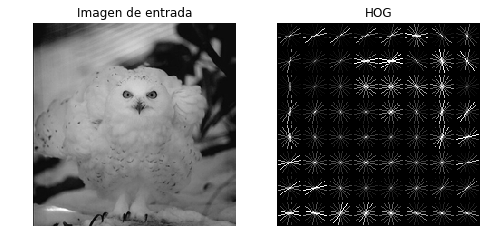

In [0]:
from skimage.feature import hog
from skimage import data, color, exposure


image = color.rgb2gray(np.array(test_img))

fd, hog_image = hog(image, orientations=8, pixels_per_cell=(28, 28),
                    cells_per_block=(1, 1), visualise=True)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)

ax1.axis('off')
ax1.imshow(image, cmap=plt.cm.gray)
ax1.set_title('Imagen de entrada')
ax1.set_adjustable('box-forced')

hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 0.02))

ax2.axis('off')
ax2.imshow(hog_image_rescaled, cmap=plt.cm.gray)
ax2.set_title('HOG')
ax1.set_adjustable('box-forced')
plt.show()

In [0]:
print('Tamaño vector de características: {}'.format(fd.shape))

Tamaño vector de características: (512,)


In [0]:
fun = extract_pixels

X_train = np.array([fun(img) for img in train])

In [0]:
X_val = np.array([fun(img) for img in val])
X_test = np.array([fun(img) for img in test])

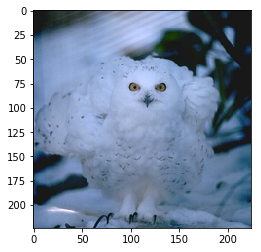

In [0]:
from PIL import Image 
t_img = Image.fromarray(img)

new_width  = 224
new_height = 224
test_img = ImageOps.fit(t_img, (new_width, new_height), Image.ANTIALIAS)

plt.imshow(test_img)

In [0]:
X = np.concatenate((X_train, X_val))
y = np.concatenate((y_train, y_val))

In [0]:
print(X.shape)
print(X_test.shape)

(300, 50176)
(300, 50176)


In [0]:
#clf = RandomForestClassifier(n_estimators=50, max_features=0.15, n_jobs=-1)
clf = RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=42)

In [0]:
clf.fit(X, y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [0]:
clf.score(X_test, y_test)

0.4666666666666667

# RandomizedSearchCV

Exploremos el número de características usadas por RandomForest.

In [0]:
from sklearn.model_selection import ShuffleSplit, GridSearchCV
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform as sp_randfloat
from scipy.stats import randint as sp_randint

#X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, random_state=1)

param_dist = {"max_features": sp_randfloat()}

clf = RandomForestClassifier(n_estimators=100)

#n_iter_search = 40
n_iter_search = 5

random_search = RandomizedSearchCV(clf, random_state=42, param_distributions=param_dist,
                                   n_iter=n_iter_search, cv=3, 
                                   n_jobs=-1, verbose=2)

random_search.fit(X, y)
random_search.score(X_test, y_test)

Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed: 33.5min finished
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


0.45666666666666667

Accuracy reportado:

* PIXELS = 41%
* HOG = 47%
* HISTO = 35%

# Taller

Vamos a usar el conjunto de datos `scene_categories`, el cual contiene imágenes de 15 escenarios como suburbios, zonas industirales, habitaciones, entre otros. El objetivo consiste en comparar las tres estrategias de extracción de características observadas:

* Cargue el conjunto de datos `scene_categories`.
* Verifique que haya cargado 4485 imágenes que pertenecen al conjunto de datos.
* Use `plt.imshow()` para visualizar un par de imágenes y verificar que se hayan cargado exitosamente los conjuntos de datos.
* Grafique la distribución de etiquetas del conjunto de datos.
* Particione el conjunto de datos de tal forma que quede 70% para entrenamiento y 30% para prueba. Haga la partición estratificada.
* Compare los 3 métodos de extracción de características usando un RandomForest con las siguientes características:
```python
RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=42)
```
    * Para HOG: use exactamente la misma función descrita arriba. Es decir, con un tamaño de parche de 28x28.
* ¿Cuál estrategia funciona mejor? ¿Por qué cree?

# Solución

Cargar el conjunto de datos scene_categories

In [0]:
!pip install pydrive

In [0]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
 
# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



In [0]:
data_file = drive.CreateFile({'id': '18zzrp_yFQJD31ShV9FzRxw3FWjjGnx4q'})
data_file.GetContentFile('data.zip')

In [0]:
# descomprimimos el archivo 
!unzip data.zip

Archive:  data.zip
  inflating: data/birds_f_numbers.txt  
  inflating: data/birds/toucan/tou019.jpg  
  inflating: data/birds/toucan/tou018.jpg  
  inflating: data/birds/toucan/tou033.jpg  
  inflating: data/birds/toucan/tou027.jpg  
  inflating: data/birds/toucan/tou025.jpg  
  inflating: data/birds/toucan/tou031.jpg  
  inflating: data/birds/toucan/tou026.jpg  
  inflating: data/birds/toucan/tou008.jpg  
  inflating: data/birds/toucan/tou020.jpg  
  inflating: data/birds/toucan/tou036.jpg  
  inflating: data/birds/toucan/tou024.jpg  
  inflating: data/birds/toucan/tou032.jpg  
  inflating: data/birds/toucan/tou030.jpg  
  inflating: data/birds/toucan/tou023.jpg  
  inflating: data/birds/toucan/tou034.jpg  
  inflating: data/birds/toucan/tou037.jpg  
  inflating: data/birds/toucan/tou051.jpg  
  inflating: data/birds/toucan/tou022.jpg  
  inflating: data/birds/toucan/tou079.jpg  
  inflating: data/birds/toucan/tou092.jpg  
  inflating: data/birds/toucan/tou086.jpg  
  inflating: data

Verificamos que se hayan cargado todas las imagenes 4485 imágenes.

In [0]:
import os
from os.path import join 
import glob 

In [0]:
dir_padre = "/content/data/scene_categories"

In [0]:
# Generamos la lista de los archivos que son imágenes con glob 
list_files = glob.glob("/content/data/scene_categories/**/*.jpg")
print("Número de archivos totales: {}".format(len(list_files)))

Número de archivos totales: 4492


En las carpetas de datos existen algunas imágenes repetidas por ello el número es mayor. Ahora procederemos a visualizar alguna de las imágenes para comprobar su correcta carga. 

In [0]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

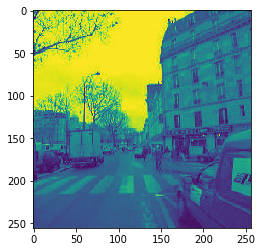

In [0]:
# Leemos la imagen 
im = mpimg.imread(list_files[0])
plt.imshow(im)

Como podemos observar la imagen se ha cargado correctamente. 

Para graficar la distribución de etiquetas del conjunto de datos, dbemos observar que las etiquetas son carpetas, obtendremos la carpeta de cada imagen y contaremos el número de veces que se repite. 

In [0]:
import pandas as pd

In [0]:
# Guardamos las rutas en un dataseries 
ds_img = pd.Series(list_files)
# creamos un nuevo dataseries y guardamos la clase de cada imagen 
ds_class = ds_img.apply(lambda x: x.split("/")[-2])
# imprimimos las primeras filas 
ds_class.head(3)

0    MITstreet
1    MITstreet
2    MITstreet
dtype: object

In [0]:
# Número de ejemplos por clase
class_freq = ds_class.value_counts()
print(class_freq)

MITopencountry     410
MITmountain        374
MITcoast           360
MITtallbuilding    356
MITforest          328
store              315
industrial         311
MITinsidecity      308
MITstreet          292
livingroom         289
MIThighway         260
CALsuburb          241
kitchen            217
bedroom            216
PARoffice          215
dtype: int64


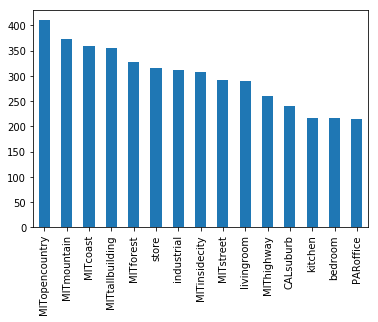

In [0]:
# Grafica de la distribución de etiquetas del conjunto de datos.
class_freq.plot(kind="bar")

In [0]:
#Partición estratificada del conjunto de datos de tal forma que quede 70% para entrenamiento y 30% para prueba.
#Llamado de la función
from sklearn.model_selection import train_test_split


In [0]:
ds_class.shape

(4492,)

In [0]:
ds_img.shape

(4492,)

In [0]:
c = ds_class.unique()

In [0]:
#Indexación de clases
class_map = {}
ck = 0
for i in c:
  class_map[i] = ck
  ck +=1


In [0]:
class_map

{'CALsuburb': 13,
 'MITcoast': 7,
 'MITforest': 2,
 'MIThighway': 1,
 'MITinsidecity': 12,
 'MITmountain': 11,
 'MITopencountry': 6,
 'MITstreet': 0,
 'MITtallbuilding': 5,
 'PARoffice': 3,
 'bedroom': 8,
 'industrial': 14,
 'kitchen': 9,
 'livingroom': 10,
 'store': 4}

In [0]:
ds_class_cod =ds_class.map(class_map)

In [0]:
#Definición de X
X = ds_img.values
X.shape

(4492,)

In [0]:
#Definición de Y
y = ds_class_cod.values
y.shape

(4492,)

In [0]:
#Partición
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.3, 
                                                    random_state=42,
                                                    stratify=y)

In [0]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(3144,)
(1348,)
(3144,)
(1348,)


In [0]:
#Reparametrización de la función que extrae caracteristicas a través del histogramad de colores
def extract_histo_2(img):
    values, _ = np.histogram(img[:,:].ravel(), bins=256, range=(0.0, 256))
    return values



In [0]:
im2 = mpimg.imread(X_train[1])

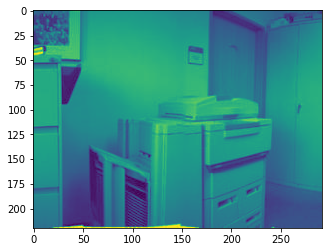

In [0]:
#Validación de la reparametrización
plt.imshow(im2)

In [0]:
#Extracción de caracteristicas a través del histograma de colores para todas las imagenes de la muestra de entrenamiento 
X_train_M = np.zeros((X_train.shape[0],256))
X_train_M.shape


(3144, 256)

In [0]:
 for i in range(0,X_train.shape[0]):
    temp_im = mpimg.imread(X_train[i])
    X_train_M[i] = extract_histo_2(temp_im)

In [0]:
X_train_M.shape

(3144, 256)

In [0]:
X_train_M

array([[  7.,   3.,   4., ...,  36.,  41., 102.],
       [  9.,   6.,   5., ...,   6.,   4.,  46.],
       [  0.,   0.,   0., ...,  21.,  14.,  72.],
       ...,
       [  1.,   0.,   0., ...,   0.,   0.,   0.],
       [ 25.,  58., 118., ..., 103., 170., 481.],
       [ 90.,  36.,  45., ...,   2.,   1.,   0.]])

In [0]:
#Extracción de caracteristicas a través del histograma de colores para todas las imagenes de la muestra de prueba
X_test_M = np.zeros((X_test.shape[0],256))
X_test_M.shape

(1348, 256)

In [0]:
for i in range(0,X_test.shape[0]):
    temp_im = mpimg.imread(X_test[i])
    X_test_M[i] = extract_histo_2(temp_im)

In [0]:
X_test_M.shape

(1348, 256)

In [0]:
X_test_M

array([[5.400e+01, 5.300e+01, 9.200e+01, ..., 2.280e+02, 2.190e+02,
        4.140e+02],
       [3.770e+02, 2.420e+02, 2.230e+02, ..., 9.000e+01, 1.520e+02,
        3.120e+02],
       [3.680e+02, 6.400e+01, 7.600e+01, ..., 4.580e+02, 6.140e+02,
        1.674e+03],
       ...,
       [0.000e+00, 0.000e+00, 1.000e+00, ..., 5.900e+01, 8.100e+01,
        1.940e+02],
       [0.000e+00, 0.000e+00, 0.000e+00, ..., 1.000e+00, 0.000e+00,
        0.000e+00],
       [0.000e+00, 0.000e+00, 0.000e+00, ..., 0.000e+00, 0.000e+00,
        0.000e+00]])

In [0]:
# Modelo 1. Random Forest para clasificar las imagenes realizando la extracción mediante el metodo de histograma de colores
clf1 = RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=42)
clf1.fit(X_train_M, y_train)
clf1.score(X_test_M, y_test)

0.34940652818991097

In [0]:
#Extracción de caracteristicas a través de pixeles para todas las imagenes de la muestra de entrenamiento 
X_train_MP = np.zeros((X_train.shape[0],224*224))
X_train_MP.shape

(3144, 50176)

In [0]:
for i in range(0,X_train.shape[0]):
    temp_im = mpimg.imread(X_train[i])
    X_train_MP[i] = extract_pixels(temp_im)


In [0]:
#Extracción de caracteristicas a través de pixeles para todas las imagenes de la muestra de prueba
X_test_MP = np.zeros((X_test.shape[0],224*224))
X_test_MP.shape

(1348, 50176)

In [0]:
for i in range(0,X_test.shape[0]):
    temp_im = mpimg.imread(X_test[i])
    X_test_MP[i] = extract_pixels(temp_im)


In [0]:
# Modelo 2. Random Forest para clasificar las imagenes realizando la extracción mediante el metodo de pixeles
clf2 = RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=42)
clf2.fit(X_train_MP, y_train)
clf2.score(X_test_MP, y_test)

0.34198813056379823

In [0]:
#Extracción de caracteristicas a través de hog para todas las imagenes de la muestra de entrenamiento
X_train_MH = np.zeros((X_train.shape[0],512))
X_train_MH.shape

(3144, 512)

In [0]:
for i in range(0,X_train.shape[0]):
    temp_im = mpimg.imread(X_train[i])
    X_train_MH[i] = extract_hog(temp_im)



/usr/local/lib/python3.6/dist-packages/skimage/feature/_hog.py:239: skimage_deprecation: Argument `visualise` is deprecated and will be changed to `visualize` in v0.16
  'be changed to `visualize` in v0.16', skimage_deprecation)


In [0]:
#Extracción de caracteristicas a través de hog para todas las imagenes de la muestra de prueba
X_test_MH = np.zeros((X_test.shape[0],512))
X_test_MH.shape

(1348, 512)

In [0]:
for i in range(0,X_test.shape[0]):
    temp_im = mpimg.imread(X_test[i])
    X_test_MH[i] = extract_hog(temp_im)


/usr/local/lib/python3.6/dist-packages/skimage/feature/_hog.py:239: skimage_deprecation: Argument `visualise` is deprecated and will be changed to `visualize` in v0.16
  'be changed to `visualize` in v0.16', skimage_deprecation)


In [0]:
# Modelo 3. Random Forest para clasificar las imagenes realizando la extracción mediante el metodo de hog
clf3 = RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=42)
clf3.fit(X_train_MH, y_train)
clf3.score(X_test_MH, y_test)

0.5519287833827893

In [0]:
# Importación de la libreria de reportes de clasificación
from sklearn.metrics import classification_report

In [0]:
# Medidas de diagnóstico del modelo 1. (histograma de colores)
y_predM = clf1.predict(X_test_M)
print(classification_report(y_test, y_predM))


              precision    recall  f1-score   support

           0       0.40      0.39      0.39        88
           1       0.55      0.65      0.60        78
           2       0.37      0.58      0.45        98
           3       0.54      0.38      0.45        65
           4       0.38      0.69      0.49        95
           5       0.30      0.34      0.31       107
           6       0.27      0.24      0.25       123
           7       0.36      0.24      0.29       108
           8       0.24      0.12      0.16        65
           9       0.22      0.08      0.11        65
          10       0.22      0.17      0.19        87
          11       0.26      0.23      0.24       112
          12       0.22      0.18      0.20        92
          13       0.47      0.58      0.52        72
          14       0.36      0.37      0.36        93

    accuracy                           0.35      1348
   macro avg       0.34      0.35      0.33      1348
weighted avg       0.34   

In [0]:
# Medidas de diagnóstico del modelo 2. (pixeles)
y_predMP = clf2.predict(X_test_MP)
print(classification_report(y_test, y_predMP))


              precision    recall  f1-score   support

           0       0.56      0.56      0.56        88
           1       0.58      0.68      0.62        78
           2       0.26      0.38      0.31        98
           3       0.62      0.58      0.60        65
           4       0.34      0.25      0.29        95
           5       0.23      0.35      0.27       107
           6       0.30      0.49      0.37       123
           7       0.28      0.37      0.32       108
           8       0.29      0.14      0.19        65
           9       0.29      0.09      0.14        65
          10       0.32      0.18      0.23        87
          11       0.29      0.28      0.28       112
          12       0.22      0.18      0.20        92
          13       0.57      0.35      0.43        72
          14       0.32      0.20      0.25        93

    accuracy                           0.34      1348
   macro avg       0.36      0.34      0.34      1348
weighted avg       0.35   

In [0]:
# Medidas de diagnóstico del modelo 3. (hog)
y_predMH = clf3.predict(X_test_MH)
print(classification_report(y_test, y_predMH))


              precision    recall  f1-score   support

           0       0.71      0.76      0.73        88
           1       0.79      0.68      0.73        78
           2       0.78      0.94      0.85        98
           3       0.68      0.42      0.51        65
           4       0.34      0.31      0.32        95
           5       0.43      0.75      0.54       107
           6       0.56      0.73      0.63       123
           7       0.66      0.75      0.70       108
           8       0.33      0.11      0.16        65
           9       0.45      0.20      0.28        65
          10       0.36      0.33      0.35        87
          11       0.52      0.60      0.55       112
          12       0.39      0.41      0.40        92
          13       0.84      0.81      0.82        72
          14       0.30      0.14      0.19        93

    accuracy                           0.55      1348
   macro avg       0.54      0.53      0.52      1348
weighted avg       0.54   

Revisando las medidas de diagnóstico de los tres modelos evaluados, se concluye que el modelo 3 es aquel que mejor compratmiento tiene. Esto puede ser debido a que la extración de caracteristicas mediante el procedimietno hog, extrae 512 ubicaciones y por tal motivo es más fácil para el sistema clasificar imagenes con menos caracteristicas.